# HW1 : Regression, Cross-Validation, and  Regularization

In [3]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
#This sets the default style for all figures. 
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

You may need to adjust your data directory to point towards the auto data. 

In [6]:
SEED = 12345 

DATA_DIR = './data_auto/'

# Helper Functions

These notebook sections contain helper functions which you **do not need to alter**.  

### Methods for loading dataset

In [9]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

### Plotting methods

In [11]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

### Method to sanitize predictions

For many regression problems certain values might be impossible or improbable (such as in this case where we can't have a negative miles-per-gallon). However, most machine learning models cannot learn these types of strict rules. Thus, a common practice in ML is to **sanatize** predictions made by a model, confining them to be within reasonable bounds. 

Here we are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

All model predictions should be sanitized before being used. 

In [13]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

## Methods for building pipelines

These are sklearn pipelines, which define a series of steps that can then be treated as if they were a single classifier.  

In [15]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [16]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

Use this function when asked to display learned parameters.

In [18]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Analysis

The rest of this notebook is an analysis and report of the automobile dataset. Some of the steps of the analysis have already been completed for you. You need to complete the indicated sections in problems 1-3.

# Load the dataset

First, we need to load the predefined 'x' and 'y' arrays for train/valid/test sets using the predefined helper function. 

In [21]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [22]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

We can then take at various parts of our training data. 

In [24]:
# Feature names
print("Feature Names:", xcolnames_F) 

# First 5 instances in our training data
print("Training data features:\n", x_tr_MF[:5])

# MPG for the first 5 instances
print("Training data MPGs:\n", y_tr_M[:5,np.newaxis])

Feature Names: ['horsepower', 'weight', 'cylinders', 'displacement']
Training data features:
 [[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]
Training data MPGs:
 [[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


Also, we need to set a `Y_MAX` variable so that the sanatize function works. 

In [26]:
# Highest MPG in the training data
y_tr_M.max()

46.6

In [27]:
Y_MAX = y_tr_M.max()*1.2

## Load completed code

Now we load in the code you wrote in part of of the homework. 

In [30]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

**Implementation Step 1A:**

Fit a linear regression model to a polynomial feature transformation of the provided training set at each of these possible degrees: [1, 2, 3, 4, 5, 6, 7]. For each hyperparameter setting, record the training set error and the validation set error in terms of RMSE.

In [32]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:
    
    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    pipeline = make_poly_linear_regr_pipeline(degree)
    pipeline.fit(x_tr_MF, y_tr_M) 
    # Compute training error
    yhat_tr_M = sanitize(pipeline.predict(x_tr_MF))  # TODO fixme, be sure to sanitize predictions
    yhat_va_N = sanitize(pipeline.predict(x_va_NF)) # TODO fixme, be sure to sanitize predictions
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme
    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)  
    # TODO store current pipeline for future use
    fv_pipeline_list.append(pipeline)


### Implementation 1B: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [34]:
print("Selected Parameters:")
my_min = min(fv_err_va_list)
min_ind = fv_err_va_list.index(my_min)
print(f"{degree_list[min_ind]}")
print("Fixed validation set estimate of heldout error:")
print(f"{my_min}")
print("Error on the test-set:")
yhat_te_PF = sanitize(fv_pipeline_list[min_ind].predict(x_te_PF))
fv_err_test_best = calc_root_mean_squared_error(y_te_P, yhat_te_PF)
print(f"{fv_err_test_best}")

Selected Parameters:
2
Fixed validation set estimate of heldout error:
3.974075330754533
Error on the test-set:
3.9915025464567577


In [35]:
# TODO store score on test set for later

### Figure 1: Error vs degree

Once `fv_err_tr_list` and `fv_err_va_list` contain values from part 1A, you can re-run the plotting cell to generate figure 1 with the values you found. 

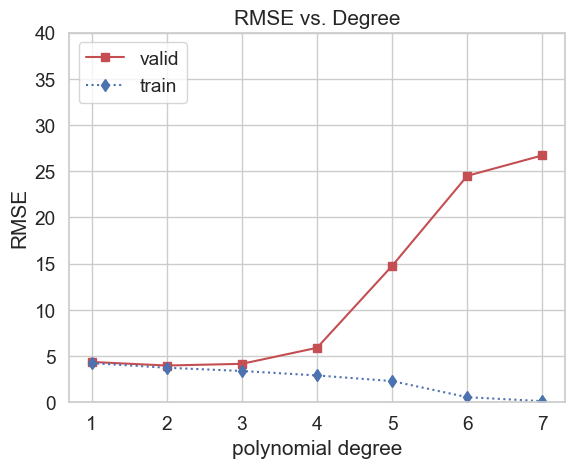

In [37]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

#### Figure 1: RMSE vs. Degree

*Provide a 2 sentence caption answering the questions: How do validation and training error change as degree increases? What degree do you recommend based on this plot?*

As degree increases, validation error climbs, while training error drops as the model fits the training data more closely. The best choice i degree two, where validation and training RMSE are still close, and the validation RMSE is at its lowest point before they diverge, signaling overfitting.

#### Short Answer 1A

The starter code pipelines include a *preprocessing* step that rescales each feature column to be in the unit interval from 0 to 1. 
Why is this necessary for this particular dataset?
What happens (in terms of both training error and test error) if this step is omitted?
*Hint: Try removing this step and see.*

We rescale our feature columns, (our inputs like weight, hp, cylinders, etc) to prevent individual features from dominating our regression. The units of our features are inconsistent and vary wildly. Features like weight or horsepower are much larger than features such as cylinders. If we dont rescale, cylinders' has an extremely tiny impact on the regression. Additionally, our training error will decrease less appreciably over larger degrees. Our test error will also go up for our smaller features, as we are overfitting more on values such as horsepower and weight over smaller features.  

#### Short Answer 1B

Consider the model with degree 1. 
Following the starter code, print out the values of **all** the learned weight parameters (aka coefficients).
From these values, which feature has the highest positive impact on MPG? Which has the highest negative impact? Do these make sense?

In [43]:
# TODO call pretty_print_learned_weights on your pipeline with degree=1 from above
pretty_print_learned_weights(fv_pipeline_list[0], xcolnames_F)
# Hint: The names of the original F=4 features are already in your workspace
print(xcolnames_F)

 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement
['horsepower', 'weight', 'cylinders', 'displacement']


The feature with the highest positive impact on MPG is displacement, though it is quite a small magnitude impact. Generally, large displacement engines to my knowledge cost more gas (I am not a car guy). This could be due to the low degree and poor fit at degree = 1. On the other hand, weight had the most negative impact on MPG. This makes sense to me, as weight increases the efficiency of our miles per gallon should drop, we are hauling something that weighs more so energy should cost more. This happens similarly with horsepower, which makes sense. If we use more horsepower to move our car, it should cost more to move it. 

# Problem 2: Alpha Selection on Fixed Val Set

#### Implementation Step 2A 

Fix the degree at 4. Consider the below possible `alpha` values for L2-penalized linear regression, aka `Ridge`.

Fit a L2-penalized linear regression pipeline for each alpha value above, then record that model's training set error and the validation set error.

In [46]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


In [47]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    pipeline = make_poly_ridge_regr_pipeline(degree=my_degree, alpha=alpha)
    pipeline.fit(x_tr_MF, y_tr_M) 

    yhat_tr_M = sanitize(pipeline.predict(x_tr_MF)) # TODO fixme, be sure to call predict and then sanitize
    yhat_va_N = sanitize(pipeline.predict(x_va_NF)) # TODO fixme, be sure to call predict and then sanitize
    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)
    
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)

    # TODO store current pipeline for future use
    fv2_pipeline_list.append(pipeline)

### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

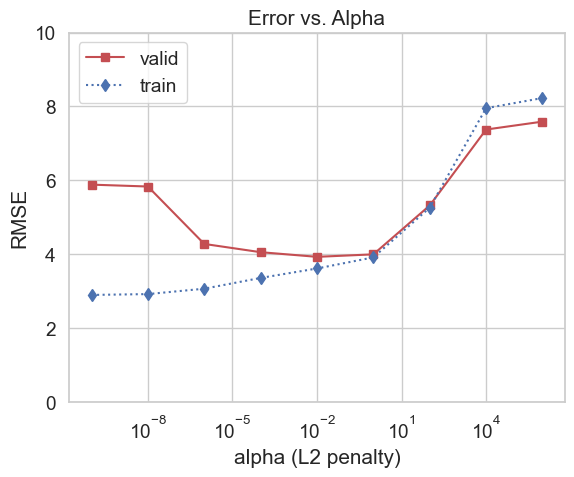

In [49]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

#### Figure 2: Error vs. Alpha

Provide a 2 sentence caption answering the questions: How do validation and training set RMSE change with alpha? Do any trends emerge?
What alpha value do you recommend based on this plot?

As alpha increases, training RMSE increases. For validation on the other hand, it decreases slowly in RMSE over the first two alpha values. From the 2nd to 3rd, the decrease is rapid, followed by a slower decrease in RMSE until the 6th alpha value, after which point it begins to increase again in RMSE. The best point is at the 6th alpha, 1.e+00. At this point, RMSE for validation is at its lowest point while training RMSE is relatively low and has converged with it. 

#### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [53]:
min_va_error = min(fv2_err_va_list) # minimum error, comments for sanity check 
best_param_index = fv2_err_va_list.index(min_va_error)
param_val = alpha_list[best_param_index]
print("Selected Parameters:")
print(f"{param_val}")
print("Fixed validation set estimate of heldout error:")
print(f"{min_va_error}")
print("Error on the test-set:")
best_pipe = fv2_pipeline_list[best_param_index]
yhat_test_P = sanitize(best_pipe.predict(x_te_PF))
test_error = calc_root_mean_squared_error(y_te_P, yhat_test_P)
print(f"{test_error}") 

Selected Parameters:
0.01
Fixed validation set estimate of heldout error:
3.931387833481258
Error on the test-set:
3.877667860403786


In [54]:
# TODO Save this test set error value for later.
# I saved the value to itself again so you can see which variable it was
test_error = test_error 

In [55]:
pretty_print_learned_weights(best_pipe, xcolnames_F)

 -39.88 : x0
   1.56 : x1
  14.71 : x2
 -13.32 : x3
  -6.53 : x0^2
  -5.93 : x0 x1
  21.96 : x0 x2
  24.36 : x0 x3
 -22.82 : x1^2
   2.39 : x1 x2
  -2.18 : x1 x3
 -19.42 : x2^2
 -26.81 : x2 x3
   3.47 : x3^2
   9.93 : x0^3
   5.41 : x0^2 x1
   9.37 : x0^2 x2
  14.07 : x0^2 x3
   8.22 : x0 x1^2
   7.41 : x0 x1 x2
  12.85 : x0 x1 x3
   0.12 : x0 x2^2
  -1.49 : x0 x2 x3
   0.97 : x0 x3^2
  -5.93 : x1^3
  -2.12 : x1^2 x2
  -2.79 : x1^2 x3
   0.19 : x1 x2^2
  -2.80 : x1 x2 x3
  -0.49 : x1 x3^2
  -4.76 : x2^3
  -3.17 : x2^2 x3
   3.10 : x2 x3^2
   5.33 : x3^3
   5.15 : x0^4
  -4.71 : x0^3 x1
  -1.87 : x0^3 x2
   5.64 : x0^3 x3
  -2.97 : x0^2 x1^2
  -5.04 : x0^2 x1 x2
   1.79 : x0^2 x1 x3
 -10.96 : x0^2 x2^2
  -4.93 : x0^2 x2 x3
  -3.79 : x0^2 x3^2
   4.44 : x0 x1^3
   2.40 : x0 x1^2 x2
   5.23 : x0 x1^2 x3
  -4.37 : x0 x1 x2^2
  -0.25 : x0 x1 x2 x3
  -1.68 : x0 x1 x3^2
 -16.61 : x0 x2^3
 -11.02 : x0 x2^2 x3
 -10.19 : x0 x2 x3^2
 -13.04 : x0 x3^3
   2.39 : x1^4
   3.05 : x1^3 x2
   0.24 : x1^

#### Short Answer 2a

Inspect the learned weight parameters of your chosen degree-4 ridge regression model.
How do their relative magnitudes compare to those you printed in 1b above?

In the degree-4 ridge regression model, the coefficients for higher-order terms and interactions between features are much larger in magnitude compared to the simpler degree-1 model. Our new model is capturing more complex relationships between features, as modeled by the higher number of coefficients we are looking at and the higher magnitudes. 

#### Short Answer 2b in Report

Your colleague suggests that you can determine the regularization strength `alpha` by minimizing the following loss on the *training* set:

$$
\text{min}_{w \in \mathbb{R}^F, b \in \mathbb{R}, \alpha \ge 0}
\quad \sum_{n=1}^N (y_n - \hat{y}(x_n, w, b))^2 + \alpha \sum_{f=1}^F w_f^2
$$

What value of $\alpha$ would you pick if you did this? Why is this problematic if your goal is to generalize to new data well?

*Hint: Which value of $\alpha$ would minimize this loss function?*

Based on his math, we could minimize the loss function by picking alpha = 0. However, this causes the model to not penalize large coefficients. As a result, the model would probably overfit as we are not really constraining it at all causing it to not generalize well. When we overfit like this, we capture noise and overfit by fitting the training data too closely. We still have to penalize large coefficients to some extent if we want to be generalizable. To prevent this, we need at least a non-zero alpha. 

# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total.

In [62]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [65]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
fv_3_pipeline_list = []
for param in ridge_param_list:
    alpha = param['alpha']
    degree = param['degree']
    # TODO make pipeline
    pipeline = make_poly_ridge_regr_pipeline(alpha = alpha, degree=degree)
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline,x_trva_LF, y_trva_L, random_state=SEED) # TODO
    
    err_tr = np.mean(tr_error_K) # TODO fixme, compute average error across all train folds
    err_va = np.mean(valid_error_K) # TODO fixme, compute average error across all heldout folds
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)
    fv_3_pipeline_list.append(pipeline)


### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [67]:
best_valid_err_3 = min(cv_valid_err_list)
best_index = cv_valid_err_list.index(best_valid_err_3)
best_pipeline_3 = fv_3_pipeline_list[best_index]
test_error3 = calc_root_mean_squared_error(y_te_P,
    sanitize(best_pipeline_3.predict(x_te_PF))) ### THIS ONE
print(test_error3)
print(cv_train_err_list[best_index])

3.8594262729823074
3.5845807


### Table 3: Comparing Pipelines on the test set

In one neat table, please compare the *test set* root-mean-squared-error (RMSE) performance for the following regressors:

* Baseline: A predictor that always guesses the *mean* $y$ value of the training set, regardless of the new test input
* The best Poly+Linear pipeline, picking degree to minimize val set error (from 1B)
* The best Poly+Ridge pipeline, fixing degree=4 and picking alpha to minimize val set error (from 2B)
* The best Poly+Ridge pipeline, picking degree and alpha to minimize 10-fold cross validation error (from 3B)

In [71]:
mean_train_prediction = np.mean(y_tr_M)
yhat_train_baseline = sanitize(np.array([mean_train_prediction] * len(y_tr_M)))
yhat_test_baseline = sanitize(np.array([mean_train_prediction] * len(y_te_P)))
yhat_valid_baseline = sanitize(np.array([mean_train_prediction] * len(y_va_N)))
baseline_train_rmse = calc_root_mean_squared_error(y_tr_M, yhat_train_baseline)
baseline_test_rmse = calc_root_mean_squared_error(y_te_P, yhat_test_baseline)
baseline_heldout_rmse = calc_root_mean_squared_error(y_va_N, yhat_valid_baseline)

In [72]:
#SANITY CHECK RETURN values
print("Baseline mean prediction:")
print(f"Test RMSE: {baseline_test_rmse:.6f}")
print(f"Train RMSE: {baseline_train_rmse:.6f}")
print(f"Heldout RMSE: {baseline_heldout_rmse:.6f}")

# Poly+Linear pipeline (1B)
print("\nPoly+Linear pipeline (1B):")
print(f"Test RMSE: {fv_err_test_best:.6f}")
print(f"Train RMSE: {fv_err_tr_list[min_ind]:.6f}")
print(f"Heldout RMSE: {my_min:.6f}")

# Poly+Ridge Alpha Search (2B)
print("\nPoly+Ridge Alpha Search (2B):")
print(f"Test RMSE: {test_error:.6f}")
print(f"Train RMSE: {fv2_err_tr_list[best_param_index]:.6f}")
print(f"Heldout RMSE: {min_va_error:.6f}")

# Poly + Ridge Grid Search (3B)
print("\nPoly + Ridge Grid Search (3B):")
print(f"Test RMSE: {test_error3:.6f}")
print(f"Train RMSE: {cv_train_err_list[best_index]:.6f}")
print(f"Heldout RMSE: {best_valid_err_3:.6f}")

Baseline mean prediction:
Test RMSE: 7.104481
Train RMSE: 8.231074
Heldout RMSE: 7.592105

Poly+Linear pipeline (1B):
Test RMSE: 3.991503
Train RMSE: 3.734677
Heldout RMSE: 3.974075

Poly+Ridge Alpha Search (2B):
Test RMSE: 3.877668
Train RMSE: 3.616048
Heldout RMSE: 3.931388

Poly + Ridge Grid Search (3B):
Test RMSE: 3.859426
Train RMSE: 3.584581
Heldout RMSE: 3.891198


TODO make a table in your report using the saved values from 1B, 2B and 3B above. You can fill in the below Markdown table. 

| Name                          | Hyperparameter Value(s)  | Test RMSE | Train RMSE |
|-------------------------------|--------------------------|-----------|------------|
| Baseline mean prediction      | None                     | TODO      | TODO       |
| Poly+Linear pipeline (1B)     | Degree = 2               | 3.991503  | 3.734677   |
| Poly+Ridge Alpha Search (2B)  | Degree = 4, Alpha = .01  | 3.877668  | 3.616048   |
| Poly + Ridge Grid Search (3B) | Degree = 3, Alpha = .001 | 3.859426  | 3.584581   |


Table 3: 
*Provide a 2-4 sentence caption answering the question: 
What pipeline in Table 3 performed best in terms of held out error, and why do you think that pipeline performed the best? 
What pipeline in Table 3 performed worst in terms of held out error, and why do you think that pipeline performed the worst?*

Poly+Ridge Grid Search (3b) performed the best in terms of held out error. It performed best because it finds the best degree and alpha at the same time, while alpha search is slightly worse because it optimizes to only find the best alpha. Baseline mean prediction only uses the mean to make its estimate, so it usually doesn't generalize. The worst pipeline is the poly linear model. It doesn't perform any ridge regularization (hence it has no alpha) making it much more prone to overfitting.

## Reflection
Please fill in the following information about your HW1 solution.

How many hours did HW1 take you? 72 hours

Did you use any resources outside of class materials and official documentation, such as StackOverflow threads or ChatGPT? If so, please list such resources below:
I did use wikipedia to look up how some of these models run for the math. 